<a href="https://colab.research.google.com/github/vaishkar/Food_images_classification/blob/main/new_code_food_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

korean food image classification

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras.api._v2.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.api._v2.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.api._v2.keras.optimizers import Adam
from keras.api._v2.keras.applications import MobileNetV2
from keras.api._v2.keras import Model
from keras.api._v2.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random
import matplotlib.cm as cm
import cv2

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-03-22 12:33:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-22 12:33:52 (72.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Load and Transform Data

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [4]:
# Walk through each directory
dataset = "/content/drive/MyDrive/dataset/korean_dataset/train/"
walk_through_dir(dataset);

There are 21 directories and 0 images in '/content/drive/MyDrive/dataset/korean_dataset/train/'.
There are 0 directories and 36 images in '/content/drive/MyDrive/dataset/korean_dataset/train/samgyupal'.
There are 0 directories and 59 images in '/content/drive/MyDrive/dataset/korean_dataset/train/pajeon'.
There are 0 directories and 44 images in '/content/drive/MyDrive/dataset/korean_dataset/train/jjajangmyeon'.
There are 0 directories and 45 images in '/content/drive/MyDrive/dataset/korean_dataset/train/ganjang_gejang'.
There are 0 directories and 46 images in '/content/drive/MyDrive/dataset/korean_dataset/train/deonjang_chigae'.
There are 0 directories and 29 images in '/content/drive/MyDrive/dataset/korean_dataset/train/bossam'.
There are 0 directories and 48 images in '/content/drive/MyDrive/dataset/korean_dataset/train/nangmyeon'.
There are 0 directories and 40 images in '/content/drive/MyDrive/dataset/korean_dataset/train/soondae'.
There are 0 directories and 45 images in '/conten

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

Filepath      Label
0    /content/drive/MyDrive/dataset/korean_dataset/...  samgyupal
1    /content/drive/MyDrive/dataset/korean_dataset/...  samgyupal
2    /content/drive/MyDrive/dataset/korean_dataset/...  samgyupal
3    /content/drive/MyDrive/dataset/korean_dataset/...  samgyupal
4    /content/drive/MyDrive/dataset/korean_dataset/...  samgyupal
..                                                 ...        ...
901  /content/drive/MyDrive/dataset/korean_dataset/...     gimbap
902  /content/drive/MyDrive/dataset/korean_dataset/...     gimbap
903  /content/drive/MyDrive/dataset/korean_dataset/...     gimbap
904  /content/drive/MyDrive/dataset/korean_dataset/...     gimbap
905  /content/drive/MyDrive/dataset/korean_dataset/...     gimbap

[906 rows x 2 columns]

Visualizing images from the dataset

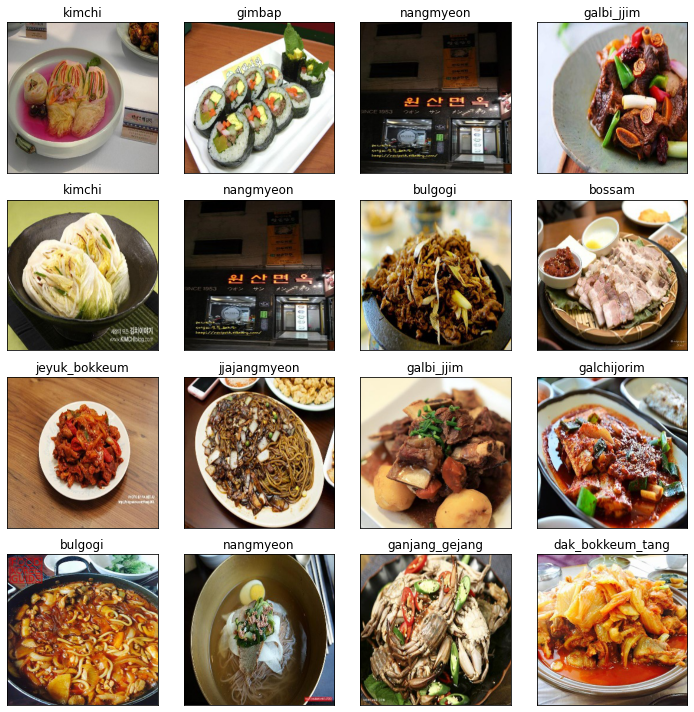

In [7]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
from PIL import Image, ImageChops, ImageEnhance

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

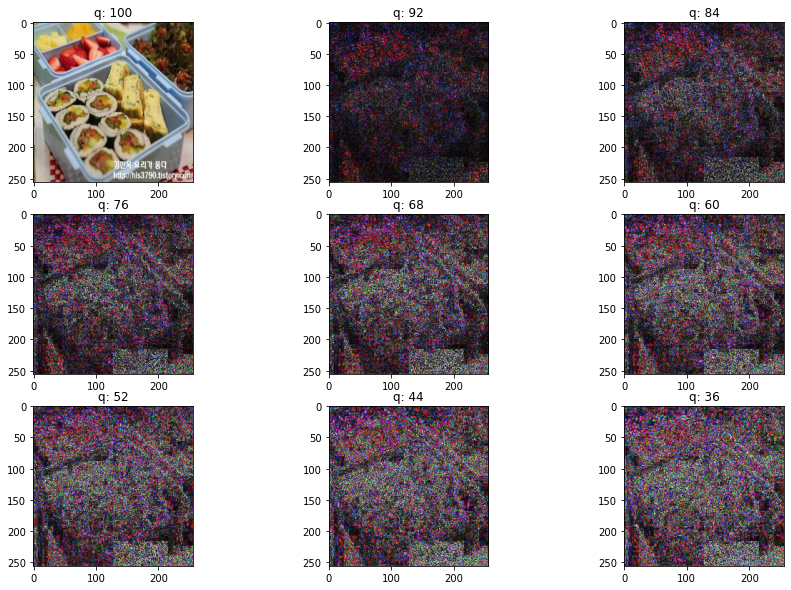

In [11]:
# View random sample from the dataset
p = random_sample('/content/drive/MyDrive/dataset/korean_dataset/train/gimbap')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Data Preprocessing

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 580 validated image filenames belonging to 20 classes.
Found 144 validated image filenames belonging to 20 classes.
Found 182 validated image filenames belonging to 20 classes.


In [15]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),

 
])

Training the model

In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [17]:
# Create checkpoint callback
checkpoint_path = "korean_classification"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)
print(checkpoint_path)

korean_classification


In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

Training the model

In [19]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(20, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [24]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    verbose=1,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("check_weight", 
                                    "checkpoint"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: check_weight/checkpoint/20230322-125839
Epoch 1/30
19/19 [==============================] - 35s 2s/step - loss: 0.8296 - accuracy: 0.8000 - val_loss: 1.3763 - val_accuracy: 0.6111
Epoch 2/30
19/19 [==============================] - 31s 2s/step - loss: 0.7479 - accuracy: 0.8328 - val_loss: 1.3534 - val_accuracy: 0.5764
Epoch 3/30
19/19 [==============================] - 35s 2s/step - loss: 0.7073 - accuracy: 0.8534 - val_loss: 1.3234 - val_accuracy: 0.5972
Epoch 4/30
19/19 [==============================] - 31s 2s/step - loss: 0.6838 - accuracy: 0.8414 - val_loss: 1.3169 - val_accuracy: 0.6111
Epoch 5/30
19/19 [==============================] - 31s 2s/step - loss: 0.6881 - accuracy: 0.8397 - val_loss: 1.3235 - val_accuracy: 0.6181
Epoch 6/30
19/19 [==============================] - 36s 2s/step - loss: 0.6128 - accuracy: 0.8638 - val_loss: 1.3048 - val_accuracy: 0.5903
Epoch 7/30
19/19 [==============================] - 35s 2s/step - loss: 0.5965 - accura

Model Evaluation

In [25]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.12736
Test Accuracy: 69.23%


Visualizing loss curves

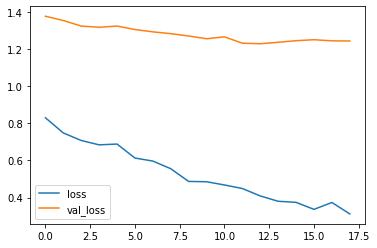

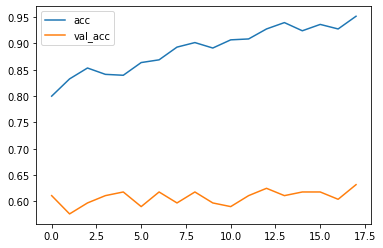

In [26]:
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

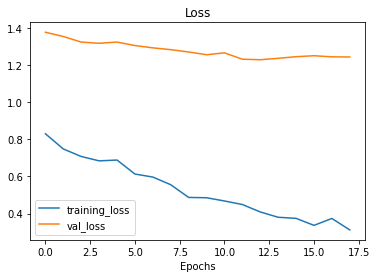

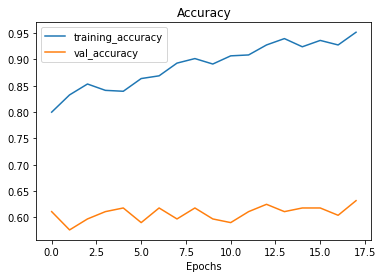

In [27]:
plot_loss_curves(history)

Making predictions on the Test Data

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')


6/6 [==============================] - 17s 2s/step
The first 10 predictions: ['gimbap', 'jeyuk_bokkeum', 'soondae', 'galchijorim', 'daegae_jjim', 'bulgogi', 'bossam', 'nangmyeon', 'gimbap', 'soondubu_jjigae']


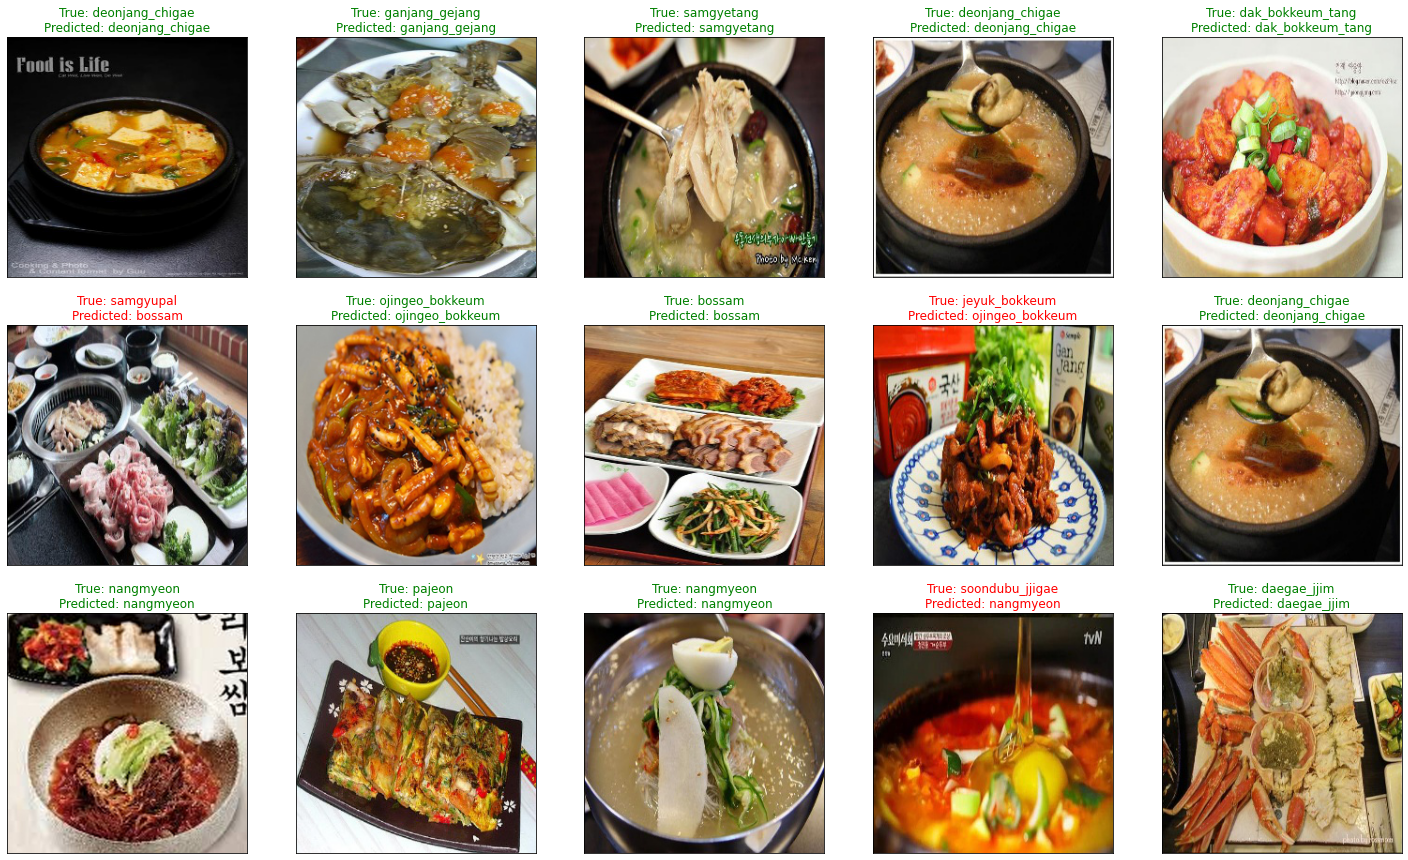

<Figure size 432x288 with 0 Axes>

In [29]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Plotting the Classification Reports and Confusion Matrix

In [30]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

        bibimbap       0.67      0.57      0.62         7
          bossam       0.62      0.83      0.71         6
         bulgogi       0.43      0.43      0.43         7
     daegae_jjim       0.88      1.00      0.93         7
dak_bokkeum_tang       0.50      0.50      0.50         4
 deonjang_chigae       0.62      0.80      0.70        10
      galbi_jjim       0.69      0.82      0.75        11
     galchijorim       0.50      0.60      0.55        10
  ganjang_gejang       0.57      0.80      0.67         5
          gimbap       0.81      1.00      0.90        13
   jeyuk_bokkeum       0.67      0.44      0.53         9
    jjajangmyeon       1.00      0.86      0.92         7
          kimchi       0.75      0.67      0.71         9
       nangmyeon       0.71      0.67      0.69        15
 ojingeo_bokkeum       0.62      0.83      0.71         6
          pajeon       0.80      1.00      0.89        16
      samgyet

In [31]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
bibimbap           0.666667  0.571429  0.615385    7.000000
bossam             0.625000  0.833333  0.714286    6.000000
bulgogi            0.428571  0.428571  0.428571    7.000000
daegae_jjim        0.875000  1.000000  0.933333    7.000000
dak_bokkeum_tang   0.500000  0.500000  0.500000    4.000000
deonjang_chigae    0.615385  0.800000  0.695652   10.000000
galbi_jjim         0.692308  0.818182  0.750000   11.000000
galchijorim        0.500000  0.600000  0.545455   10.000000
ganjang_gejang     0.571429  0.800000  0.666667    5.000000
gimbap             0.812500  1.000000  0.896552   13.000000
jeyuk_bokkeum      0.666667  0.444444  0.533333    9.000000
jjajangmyeon       1.000000  0.857143  0.923077    7.000000
kimchi             0.750000  0.666667  0.705882    9.000000
nangmyeon          0.714286  0.666667  0.689655   15.000000
ojingeo_bokkeum    0.625000  0.833333  0.714286    6.000000
pajeon             0.800000  1.000000  0.888889   16.000000
samgyetang         0.857143  0.857143  0.857143    7.000000
samgyupal          0.500000  0.333333  0.400000    6.000000
soondae            0.857143  0.375000  0.521739   16.000000
soondubu_jjigae    0.500000  0.363636  0.421053   11.000000
accuracy           0.692308  0.692308  0.692308    0.692308
macro avg          0.677855  0.687444  0.670048  182.000000
weighted avg       0.697578  0.692308  0.679247  182.000000

In [32]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

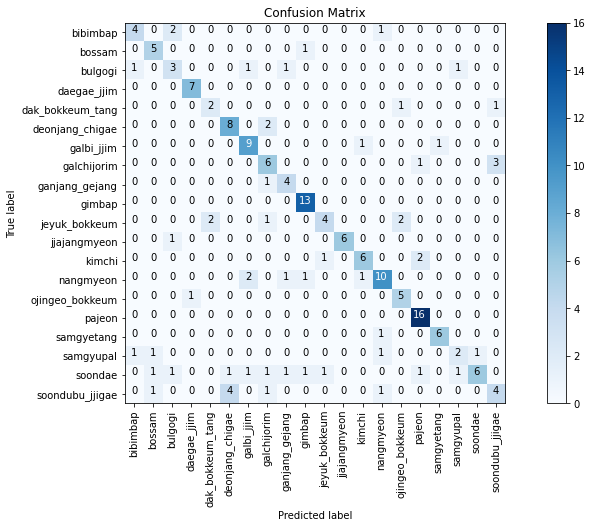

In [33]:
make_confusion_matrix(y_test, pred, list(labels.values()))

Grad-Cam Visualization

In [34]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-34-ccc8f9e1384d>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


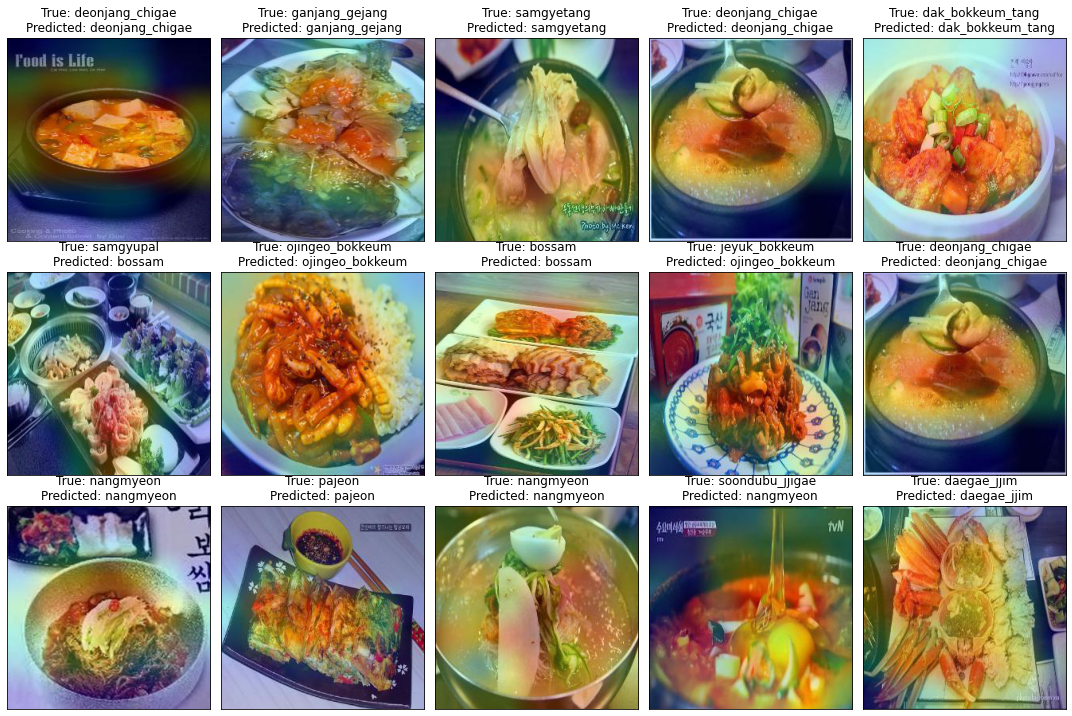

In [35]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()
